In [1]:
import torch
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from lib.utils import *
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
data_dir = "images"
classes = os.listdir(data_dir+"/train")
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

torch.Size([3, 224, 224]) 0
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
angry


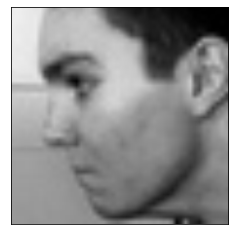

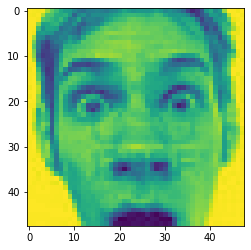

In [3]:
transforms_ = transforms.Compose([transforms.Resize(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
trainset = ImageFolder(data_dir+"/train", transform=transforms_)
img, label = trainset[5]
print(img.shape, label)
print(trainset.classes)
print(trainset.classes[label])
plt.xticks([])
plt.yticks([])
plt.imshow(img.permute(1, 2, 0)/2 + 0.5); 
import matplotlib.pyplot as plt
import matplotlib.image as img 
import matplotlib.patches as mpatches 
img =plt.imread('images\\images\\train\\surprise\\178.jpg')

figure, ax = plt.subplots(1)

rect1 =mpatches.Rectangle((1280,1650),150,50, edgecolor='r', facecolor="none") 


ax.add_patch(rect1) 
ax.imshow(img) 



import cv2
  
originalImage = cv2.imread('images\\images\\train\\surprise\\178.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
  
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
 


In [4]:
random_seed = 42
torch.manual_seed(random_seed);

val_size = 2800
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)

(26021, 2800)

In [5]:
batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

In [6]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0)/2 + 0.5) 
        break

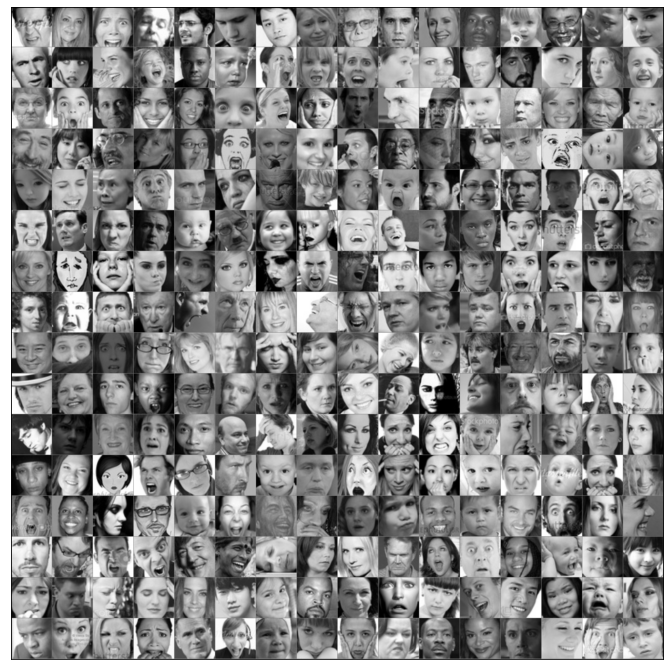

In [7]:
show_batch(train_dl)

In [8]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
def get_default_device():
   
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cpu')

In [11]:
class Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        for params in self.model.parameters():
            params.requires_grad = False
        input_shape = self.model.fc.in_features
        self.model.fc = nn.Sequential(nn.Linear(input_shape, 1024),
                                 nn.Linear(1024,7))
        print("New Layers Added:")
        for params in self.model.parameters():
            if params.requires_grad:
                print(params.shape)
    
    def forward(self,x):
        return self.model(x)

[[2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 ...
 [2 2 2 ... 1 7 7]
 [2 2 2 ... 7 7 7]
 [2 2 2 ... 7 7 7]]


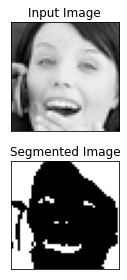

[[1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


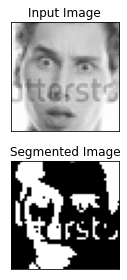

[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


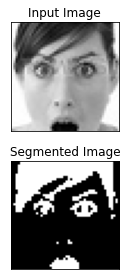

[[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]


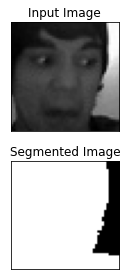

[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


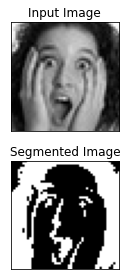

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]


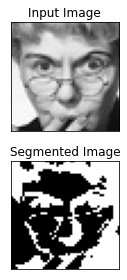

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


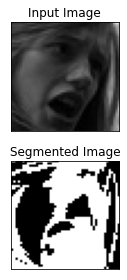

[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


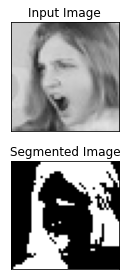

[[2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 ...
 [8 8 8 ... 6 6 6]
 [8 8 8 ... 6 6 6]
 [8 8 8 ... 6 6 6]]


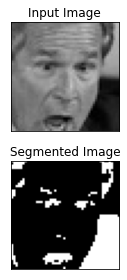

[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [8 8 8 ... 7 7 7]
 [8 8 8 ... 7 7 7]
 [8 8 8 ... 7 7 7]]


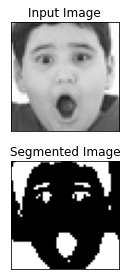

[[2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]


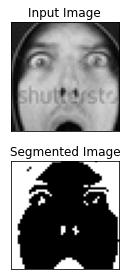

[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]


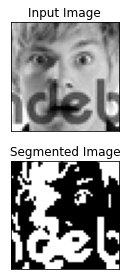

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]]


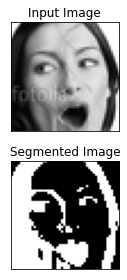

[[2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 ...
 [2 2 2 ... 7 7 7]
 [2 2 2 ... 7 7 7]
 [2 2 2 ... 7 7 7]]


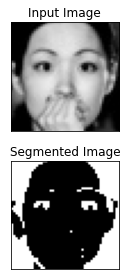

[[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


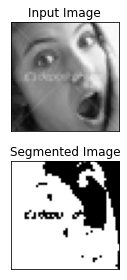

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


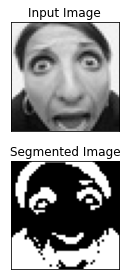

[[1 1 1 ... 1 1 4]
 [1 1 1 ... 1 1 4]
 [1 1 1 ... 1 1 4]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


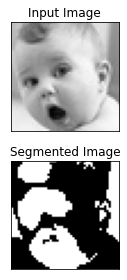

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [2 2 2 ... 2 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]


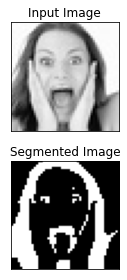

[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]]


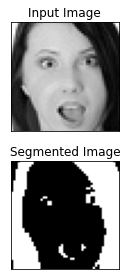

In [12]:
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from skimage.feature import greycomatrix, greycoprops
filenames = os.listdir("images\\images\\train\\surprise")
for i in range(1,20):
    sample = random.choice(filenames)
    img = cv2.imread("images\\images\\train\\surprise\\"+sample)
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    glcm = greycomatrix(img[3], distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    kernel = np.ones((2,2),np.uint8)

    closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

    sure_bg = cv2.dilate(closing,kernel,iterations=3)

    dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)

    ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)

    markers = markers+1
    print(markers)
    markers[unknown==255] = 0
    markers = cv2.watershed(img,markers)
    img[markers == -1] = [255,0,0]
    plt.subplot(211),plt.imshow(rgb_img)
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(212),plt.imshow(thresh, 'gray')
    plt.imsave(r'thresh.png',thresh)
    plt.title("Segmented Image"), plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()

Extracted_Feature:[[  4   4   4]
 [  3   3   3]
 [  4   4   4]
 [  2   2   2]
 [  4   4   4]
 [  8   8   8]
 [  3   3   3]
 [ 26  26  26]
 [ 62  62  62]
 [ 31  31  31]
 [ 20  20  20]
 [ 27  27  27]
 [ 31  31  31]
 [ 25  25  25]
 [ 34  34  34]
 [ 36  36  36]
 [ 37  37  37]
 [ 39  39  39]
 [ 61  61  61]
 [ 69  69  69]
 [ 96  96  96]
 [117 117 117]
 [142 142 142]
 [143 143 143]
 [137 137 137]
 [134 134 134]
 [167 167 167]
 [175 175 175]
 [166 166 166]
 [154 154 154]
 [154 154 154]
 [180 180 180]
 [174 174 174]
 [171 171 171]
 [157 157 157]
 [137 137 137]
 [112 112 112]
 [ 78  78  78]
 [ 62  62  62]
 [ 66  66  66]
 [ 81  81  81]
 [ 69  69  69]
 [ 38  38  38]
 [ 30  30  30]
 [ 66  66  66]
 [ 60  60  60]
 [ 45  45  45]
 [ 21  21  21]]


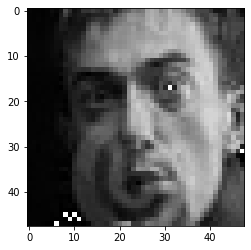

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
for i in range(1,2):
    sample = random.choice(filenames)
    img = cv2.imread("images\\images\\train\\surprise\\"+sample)

    plt.imshow(img)
    blue,green,red = cv2.split(img)
    pca = PCA(20)


    red_transformed = pca.fit_transform(red)
    red_inverted = pca.inverse_transform(red_transformed)
    green_transformed = pca.fit_transform(green)
    green_inverted = pca.inverse_transform(green_transformed)
    blue_transformed = pca.fit_transform(blue)
    blue_inverted = pca.inverse_transform(blue_transformed)
    feature_red = (np.dstack((red_inverted, red_inverted, red_inverted))).astype(np.uint8)
    plt.imshow(feature_red)
    print("Extracted_Feature:"+str(feature_red[1]))

In [14]:
model = Model()
model

New Layers Added:
torch.Size([1024, 512])
torch.Size([1024])
torch.Size([7, 1024])
torch.Size([7])


Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
       
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split

from lib.utils import *
X,y=extract_feature(train_dl)
ac=[]
pr=[]

random_state=0.9
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.70, random_state=2)

In [18]:
from sklearn.svm import SVC
model=SVC(gamma='auto')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ac.append(accuracy_score(y_pred,y_test,sample_weight=0.4)*100)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
logistic = LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)

model = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ac.append(accuracy_score(y_pred,y_test,sample_weight=0.8)*100)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -15.61, time = 0.01s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -24.84, time = 0.01s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -34.07, time = 0.01s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -43.29, time = 0.01s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -52.52, time = 0.01s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -61.74, time = 0.01s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -70.97, time = 0.01s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -80.20, time = 0.01s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -89.42, time = 0.01s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -98.65, time = 0.01s


Accuracy of SVM is 90.8 and DBN is 89.66


C:\Users\ssvin\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(80.0, 100.0)

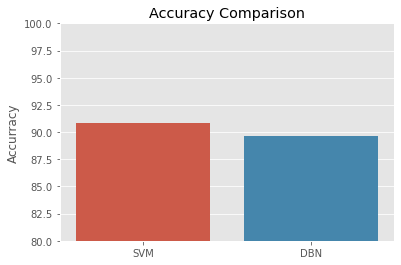

In [20]:
plt.style.use('ggplot')
x=['SVM','DBN']

import math
ax=sns.barplot(x,ac[:2])
ax.set_title('Accuracy Comparison')
ax.set_ylabel('Accurracy')

print("Accuracy of {} is {} and {} is {}".format(x[0],ac[0],x[1],ac[1]))
low = min(y)
high = max(y)
ax.set_ylim(80,100)

Model Prediction:SVM
predicted:Angry


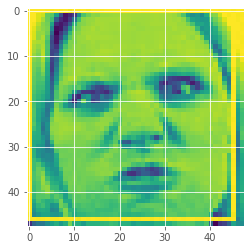

In [21]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import cv2
from lib.utils import *


import matplotlib.pyplot as plt
import matplotlib.image as img 

s=predict_model('images\\images\\train\\angry\\120.jpg',1)
img =plt.imread('my1.jpg')
print("Model Prediction:"+str(x[0]))
print("predicted:"+str(s))

figure, ax = plt.subplots(1)
ax.imshow(img)

Model Prediction:DBN
predicted:Happy


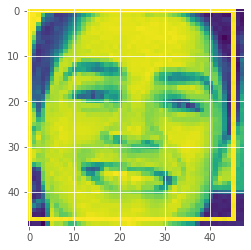

In [23]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import cv2



import matplotlib.pyplot as plt
import matplotlib.image as img 

s=predict_model('images\\images\\train\\happy\\67.jpg',2)
print("Model Prediction:"+str(x[1]))
print("predicted:"+str(s))
img =plt.imread('my1.jpg')

figure, ax = plt.subplots(1)
ax.imshow(img)